# Pyro models

Load data and libraries

In [35]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
from pyprojroot import here
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.optim import Adam
from scipy.stats import poisson
import torch
import seaborn as sns

data = pd.read_csv(here("data/recent_donations.csv"))
data

# remove columns y_2020 to y_2023
# data = data.drop(columns=["y_2020", "y_2021", "y_2022", "y_2023"])

,unique_number,class_year,birth_year,first_donation_year,gender,y_2009,y_2010,y_2011,y_2012,y_2013,y_2014,y_2015,y_2016,y_2018,y_2019,y_2017,y_2020,y_2021,y_2022,y_2023
0,26308560,"(1960,1970]",1965,1985,M,0,0,0,0,0,0,0,0,0,0,0,1,1,3,1
1,26309283,"(1960,1970]",1966,2002,M,2,1,2,2,1,1,3,3,4,1,3,3,3,3,4
2,26317365,"(1960,1970]",1961,1984,M,4,2,3,3,3,4,3,3,2,3,3,2,0,1,0
3,26318451,"(1960,1970]",1967,1989,M,0,3,3,4,4,4,2,3,3,1,2,3,1,0,0
4,26319465,"(1960,1970]",1964,1994,F,1,2,2,1,2,1,1,0,0,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9231,27220599,"(1970,1980]",1980,2022,M,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
9232,27220806,"(2000,2010]",2002,2022,M,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3
9233,27221247,"(1990,2000]",2000,2022,F,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
9234,27221274,"(1960,1970]",1966,2022,F,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3


Clean the dataframe and divide it into the time series and the covariates of our model

In [155]:
# Arrange the columns so that the years are in order
years = sorted([col for col in data.columns if col.startswith('y_')])
obs = data[years].values  # shape: [N, T]
obs = np.nan_to_num(obs, nan=0).astype(int)

# Encode gender: M=0, F=1
data['gender_code'] = (data['gender'] == 'F').astype(int)

# Normalize birth_year
birth_year_mean = data['birth_year'].mean()
birth_year_std = data['birth_year'].std()
data['birth_year_norm'] = (data['birth_year'] - birth_year_mean) / birth_year_std

years_num = np.array([int(y[2:]) for y in years])  # [2009, ..., 2023]
ages = years_num[None, :] - data['birth_year'].values[:, None]
# Normalize
ages_norm = (ages - ages.mean()) / ages.std()

# Covariates: example with birth_year_norm and gender_code, later we can add more
covariates = data[['birth_year_norm', 'gender_code']].values  # shape: [N, 2]

# Repeat covariates for all years (if fixed per individual), for example with age we should update it for each year
covariates = np.repeat(covariates[:, None, :], len(years), axis=1)  # shape: [N, T, num_covariates]

# Convert everything to torch tensors
obs_torch = torch.tensor(obs, dtype=torch.long)
covariates_torch = torch.tensor(covariates, dtype=torch.float)

# Add normalized age as a covariate
covariates = np.concatenate([covariates, ages_norm[:, :, None]], axis=2)  # shape: [N, T, 3]
covariates_torch = torch.tensor(covariates, dtype=torch.float)


covid_years = np.isin(years_num, [2020, 2021, 2022]).astype(float)  # [T]
covid_years = np.tile(covid_years, (obs.shape[0], 1))               # [N, T]

# Espandi ages_norm e covid_years per concatenarli lungo l'asse delle covariate (ultima)
ages_norm_exp = ages_norm[:, :, None]           # [N, T, 1]
covid_years_exp = covid_years[:, :, None]       # [N, T, 1]

# Crea full_covariates aggiungendo le nuove covariate alle precedenti
full_covariates = np.concatenate([covariates, ages_norm_exp, covid_years_exp], axis=2)  # [N, T, C+2]

# Conversione a torch tensor (opzionale)
full_covariates_torch = torch.tensor(full_covariates, dtype=torch.float)

## HMM without covariates

Let’s start with our models!
First of all, we will start with a Hidden Markov Model. We don’t use a classic HMM with a Gaussian as emission probabilities but a categorical (discrete) emission distribution, where each hidden state emits observable symbols according to its own categorical probability vector.

For inference, we use Stochastic Variational Inference (SVI), which allows us to approximate the posterior distributions of the model parameters efficiently. The optimization is performed using the Adam optimizer, an adaptive learning rate method that helps the model converge quickly and stably during training.

In [38]:
from pyro.infer import SVI, TraceEnum_ELBO  

num_states = 3  # Number of hidden states
num_obs = int(obs_torch.max().item()) + 1

pyro.clear_param_store()  # resetta tutti i parametri!


def model(observations):
    N, T = observations.shape
    num_states = 3

    emission_probs = pyro.param(
        "emission_probs", torch.ones(num_states, num_obs) / num_obs,
        constraint=dist.constraints.simplex)
    trans_probs = pyro.param(
        "trans_probs", torch.ones(num_states, num_states) / num_states,
        constraint=dist.constraints.simplex)
    init_probs = pyro.param(
        "init_probs", torch.ones(num_states) / num_states,
        constraint=dist.constraints.simplex)

    with pyro.plate("individuals", N):
        state = pyro.sample("state_0", dist.Categorical(init_probs))
        for t in range(T):
            pyro.sample(
                f"obs_{t}",
                dist.Categorical(probs=emission_probs[state]),
                obs=observations[:, t]
            )
            if t < T - 1:
                state = pyro.sample(
                    f"state_{t+1}",
                    dist.Categorical(trans_probs[state])
                )

def guide(observations): pass

optimizer = Adam({"lr": 0.05})
svi = SVI(model, guide, optimizer, loss=TraceEnum_ELBO())

for step in range(2000):
    loss = svi.step(obs_torch)
    if step % 200 == 0:
        print(f"Loss at step {step}: {loss}")

# Dopo l'allenamento:
emission_probs = pyro.param("emission_probs").detach().cpu().numpy()
trans_probs = pyro.param("trans_probs").detach().cpu().numpy()
init_probs = pyro.param("init_probs").detach().cpu().numpy()
print("Emission probabilities:\n", emission_probs)
print("Transition probabilities:\n", trans_probs)
print("Initial probabilities:\n", init_probs)

Loss at step 0: 400431.4375


c:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\util.py:303: UserWarning: Found vars in model but not guide: {'state_9', 'state_5', 'state_12', 'state_2', 'state_0', 'state_8', 'state_11', 'state_10', 'state_14', 'state_3', 'state_4', 'state_6', 'state_7', 'state_13', 'state_1'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
c:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\infer\traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(


Loss at step 200: 301511.28125
Loss at step 400: 255261.28125
Loss at step 600: 258977.015625
Loss at step 800: 260479.65625
Loss at step 1000: 254501.046875
Loss at step 1200: 237411.953125
Loss at step 1400: 254728.765625
Loss at step 1600: 235379.375
Loss at step 1800: 219442.765625
Emission probabilities:
 [[5.5875540e-01 2.0057279e-01 1.5068510e-01 7.2942980e-02 1.6975543e-02
  6.8148314e-05]
 [5.9998983e-01 1.7862082e-01 1.3574381e-01 6.9113374e-02 1.6403262e-02
  1.2893505e-04]
 [6.9325769e-01 1.2609529e-01 1.0672218e-01 5.9095815e-02 1.4432231e-02
  3.9666973e-04]]
Transition probabilities:
 [[0.755773   0.2412657  0.00296131]
 [0.75706387 0.22536382 0.01757236]
 [0.00729555 0.97483724 0.01786724]]
Initial probabilities:
 [0.03262165 0.8267688  0.14060953]


We define a function to plot easily the parameters of the model just trained. In the plot there are the three main components of a HMM:
the initial state probabilities, the transition matrix between hidden states, and the emission probabilities.

In this case, the initial state distribution suggests that most individuals start in state 1, indicating a possible homogeneity at the beginning of the observed period. 
The transition matrix reveals that state 0 is relatively stable (high self-transition probability), while state 1 tends to transition to state 0, and state 2 to state 1, suggesting a possible progression or hierarchy among the states. However, the emission probabilities are very similar across states, which indicates that the model struggles to distinguish between the latent states based on the observed data. 
This lack of separation is also reflected in the transition matrix suggesting frequent transitions between states. Overall, this may point to either insufficient information in the observations to clearly identify distinct latent states, or to a model with more states than necessary for the data.



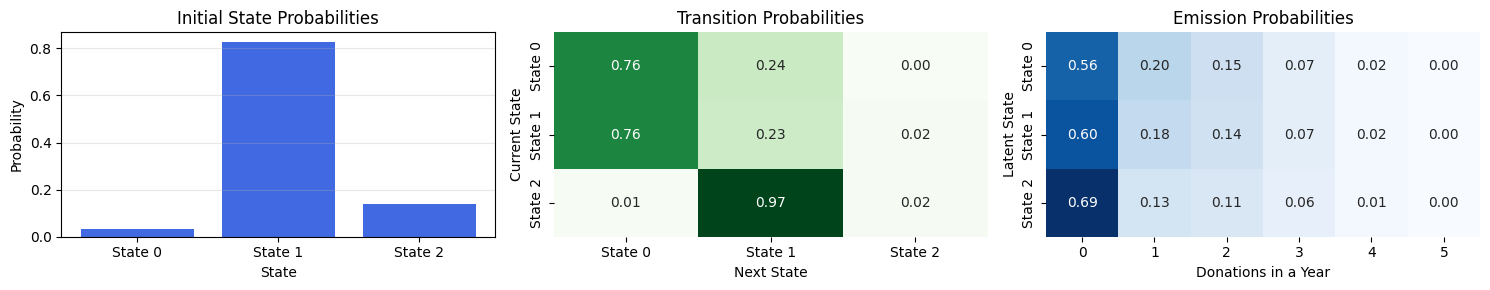

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_hmm_params(transitions, initial_probs, emissions,
                    state_names=None, emission_names=None):
    """
    Plotta in una riga:
    - Matrice di transizione [S, S]
    - Prob iniziali [S]
    - Matrice emissioni [S, K]
    """
    S = len(initial_probs)
    K = emissions.shape[1]
    if state_names is None:
        state_names = [f"State {i}" for i in range(S)]
    if emission_names is None:
        emission_names = [str(i) for i in range(K)]

    fig, axs = plt.subplots(1, 3, figsize=(15, 3))

    # Initial probabilities
    axs[0].bar(np.arange(S), initial_probs, color='royalblue')
    axs[0].set_title('Initial State Probabilities')
    axs[0].set_xlabel('State')
    axs[0].set_ylabel('Probability')
    axs[0].set_xticks(np.arange(S))
    axs[0].set_xticklabels(state_names)
    axs[0].grid(axis='y', alpha=0.3)

    # Transition matrix
    sns.heatmap(transitions, annot=True, fmt=".2f", cmap='Greens',
                xticklabels=state_names, yticklabels=state_names, ax=axs[1], cbar=False)
    axs[1].set_title('Transition Probabilities')
    axs[1].set_xlabel('Next State')
    axs[1].set_ylabel('Current State')

    # Emission probabilities/matrix
    sns.heatmap(emissions, annot=True, fmt=".2f", cmap='Blues',
                xticklabels=emission_names, yticklabels=state_names, ax=axs[2], cbar=False)
    axs[2].set_title('Emission Probabilities')
    axs[2].set_xlabel('Donations in a Year')
    axs[2].set_ylabel('Latent State')

    plt.tight_layout()
    plt.show()

# Plot the learned parameters
plot_hmm_params(
    transitions=trans_probs,
    initial_probs=init_probs,
    emissions=emission_probs)

## Full Pyro

### Poisson

In this section, unlike the previous approach, we explicitly define prior distributions for the HMM parameters (initial state, transition matrix, emission rates) using pyro.sample. The guide function introduces variational distributions (with learnable parameters) for these latent variables, enabling fully Bayesian inference via SVI. This allows us to incorporate prior knowledge and quantify uncertainty over the model parameters.

In [88]:
def model(observations):
    N, T = observations.shape
    num_states = 3

    # If I want to use specific priors, I can define them here
    # rates_prior_shape = torch.tensor([8.0, 5.0, 1.5])
    # rates_prior_rate  = torch.ones(num_states)
    # pi_prior = torch.tensor([10.0, 5.0, 1.0])
    # pi = pyro.sample("pi", dist.Dirichlet(pi_prior))
    # A = pyro.sample("A", dist.Dirichlet(torch.ones(num_states, num_states)).to_event(1))
    # rates = pyro.sample("rates",dist.Gamma(rates_prior_shape, rates_prior_rate).to_event(1))

    pi = pyro.sample("pi", dist.Dirichlet(torch.ones(num_states)))
    A = pyro.sample("A", dist.Dirichlet(torch.ones(num_states, num_states)).to_event(1))
    rates = pyro.sample("rates", dist.Gamma(2.0 * torch.ones(num_states), torch.ones(num_states)).to_event(1))

    with pyro.plate("donors", N):
        x = pyro.sample("PD_0", dist.Categorical(pi), infer={"enumerate": "parallel"})
        for t in pyro.markov(range(T)):
            x = pyro.sample(f"PD_{t+1}", dist.Categorical(A[x]), infer={"enumerate": "parallel"})
            pyro.sample(f"ND_{t}", dist.Poisson(rates[x]), obs=observations[:, t])

def guide(observations):
    num_states = 3
    pi_alpha = pyro.param("pi_alpha", torch.ones(num_states), constraint=dist.constraints.positive)
    A_alpha = pyro.param("A_alpha", torch.ones(num_states, num_states), constraint=dist.constraints.positive)
    rates_alpha = pyro.param("rates_alpha", 2.0 * torch.ones(num_states), constraint=dist.constraints.positive)
    rates_beta = pyro.param("rates_beta", torch.ones(num_states), constraint=dist.constraints.positive)
    
    # pi_alpha = pyro.param("pi_alpha", torch.tensor([2.0, 1.0, 0.5]), constraint=dist.constraints.positive)
    # rates_alpha = pyro.param("rates_alpha", torch.tensor([4.0, 2.0, 1.0]), constraint=dist.constraints.positive)

    pyro.sample("pi", dist.Dirichlet(pi_alpha))
    pyro.sample("A", dist.Dirichlet(A_alpha).to_event(1))
    pyro.sample("rates", dist.Gamma(rates_alpha, rates_beta).to_event(1))

pyro.clear_param_store()  # resetta tutti i parametri!

optimizer = Adam({"lr": .1})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, guide, optimizer, loss=elbo)


for step in range(2000):
    loss = svi.step(obs_torch)
    if step % 200 == 0:
        print(f"Step {step} loss: {loss}")

Step 0 loss: 173470.40625
Step 200 loss: 137183.265625
Step 400 loss: 149550.734375
Step 600 loss: 130798.921875
Step 800 loss: 132010.28125
Step 1000 loss: 131106.65625
Step 1200 loss: 130757.53125
Step 1400 loss: 130816.1328125
Step 1600 loss: 130666.1640625
Step 1800 loss: 131303.4375


In [89]:
learned_pi = pyro.param("pi_alpha").detach().cpu().numpy()
learned_A = pyro.param("A_alpha").detach().cpu().numpy()
learned_rates_alpha = pyro.param("rates_alpha").detach().cpu().numpy()
learned_rates_beta = pyro.param("rates_beta").detach().cpu().numpy()


pi_norm = learned_pi / learned_pi.sum()
A_norm = learned_A / learned_A.sum()
rates_norm = learned_rates_alpha / learned_rates_beta

print("Initial state probabilities (normalized):", pi_norm)
print("Transition matrix (normalized):", A_norm)
print("Poisson rates:", rates_norm)

Initial state probabilities (normalized): [0.00198279 0.14994904 0.84806824]
Transition matrix (normalized): [[1.4430614e-01 1.8874713e-04 1.1168744e-03]
 [8.4352428e-03 2.5033113e-01 4.1714776e-04]
 [5.7374258e-02 1.8518262e-02 5.1931220e-01]]
Poisson rates: [0.780297   2.0785418  0.00218539]


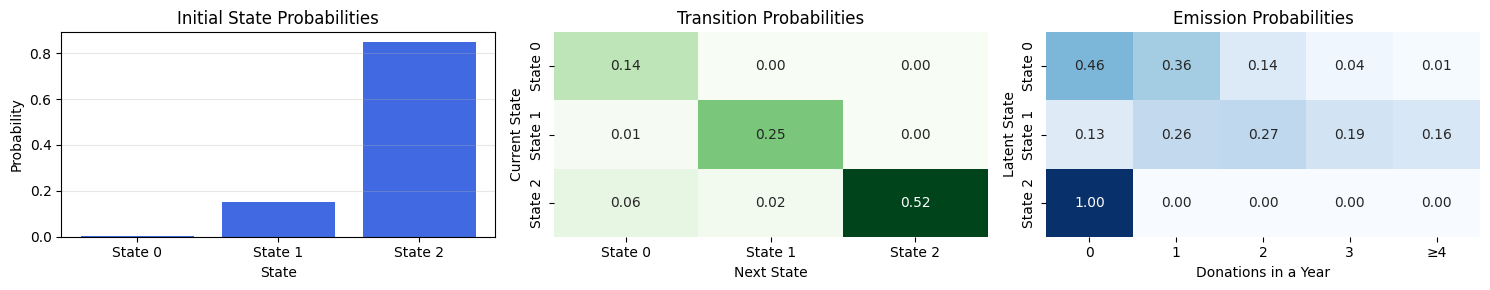

In [90]:
def build_emission_matrix_truncated_poisson(rates, max_k=4):
    S = len(rates)
    K = max_k + 1   # da 0 a max_k incluso
    emissions = np.zeros((S, K))
    for s in range(S):
        for k in range(max_k):
            emissions[s, k] = poisson.pmf(k, rates[s])
        # L'ultimo raccoglie la coda (tutto >= max_k)
        emissions[s, max_k] = 1 - poisson.cdf(max_k-1, rates[s])
    return emissions

emissions_matrix = build_emission_matrix_truncated_poisson(rates_norm, max_k=4)

plot_hmm_params(
    transitions=A_norm,
    initial_probs=pi_norm,
    emissions=emissions_matrix,
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

### Testing

In [93]:
# Dati finti, gli do una prior per fare testing
pi_true = torch.tensor([[0.00198279, 0.14994904, 0.84806824]])
A_true = torch.tensor([[1.4430614e-01, 1.8874713e-04, 1.1168744e-03],
 [8.4352428e-03, 2.5033113e-01, 4.1714776e-04],
 [5.7374258e-02, 1.8518262e-02, 5.1931220e-01]])
rates_true = torch.tensor([0.780297,   2.0785418,  0.00218539])
states = [torch.multinomial(pi_true, 1).item()]

def model(observations):
    N, T = observations.shape
    num_states = 3
    pi = pyro.sample("pi", dist.Dirichlet(torch.ones(num_states)))
    A = pyro.sample("A", dist.Dirichlet(torch.ones(num_states, num_states)).to_event(1))
    rates = pyro.sample("rates", dist.Gamma(2.0 * torch.ones(num_states), torch.ones(num_states)).to_event(1))
    with pyro.plate("donors", N):
        x = pyro.sample("PD_0", dist.Categorical(pi), infer={"enumerate": "parallel"})
        for t in pyro.markov(range(T)):
            x = pyro.sample(f"PD_{t+1}", dist.Categorical(A[x]), infer={"enumerate": "parallel"})
            pyro.sample(f"ND_{t}", dist.Poisson(rates[x]), obs=observations[:, t])

def guide(observations):
    num_states = 3
    pi_alpha = pyro.param("pi_alpha", torch.ones(num_states), constraint=dist.constraints.positive)
    A_alpha = pyro.param("A_alpha", torch.ones(num_states, num_states), constraint=dist.constraints.positive)
    rates_alpha = pyro.param("rates_alpha", 2.0 * torch.ones(num_states), constraint=dist.constraints.positive)
    rates_beta = pyro.param("rates_beta", torch.ones(num_states), constraint=dist.constraints.positive)

    pyro.sample("pi", dist.Dirichlet(pi_alpha))
    pyro.sample("A", dist.Dirichlet(A_alpha).to_event(1))  
    pyro.sample("rates", dist.Gamma(rates_alpha, rates_beta).to_event(1))

pyro.clear_param_store()  # resetta tutti i parametri!

optimizer = Adam({"lr": .10})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, guide, optimizer, loss=elbo)

for step in range(400):
    loss = svi.step(obs_torch)
    if step % 20 == 0:
        print(f"Step {step}, loss: {loss}")

Step 0, loss: 212172.40625
Step 20, loss: 143832.015625
Step 40, loss: 141319.953125
Step 60, loss: 139238.84375
Step 80, loss: 135870.765625
Step 100, loss: 142264.84375
Step 120, loss: 145849.734375
Step 140, loss: 161857.6875
Step 160, loss: 148569.015625
Step 180, loss: 136470.625
Step 200, loss: 133967.640625
Step 220, loss: 135980.0
Step 240, loss: 132120.140625
Step 260, loss: 142735.53125
Step 280, loss: 136673.546875
Step 300, loss: 134834.59375
Step 320, loss: 132765.859375
Step 340, loss: 131134.703125
Step 360, loss: 133493.8125
Step 380, loss: 139458.28125


In [94]:
learned_pi = pyro.param("pi_alpha").detach().cpu().numpy()
learned_A = pyro.param("A_alpha").detach().cpu().numpy()
learned_rates_alpha = pyro.param("rates_alpha").detach().cpu().numpy()
learned_rates_beta = pyro.param("rates_beta").detach().cpu().numpy()


pi_norm = learned_pi / learned_pi.sum()
A_norm = learned_A / learned_A.sum()
rates_norm = learned_rates_alpha / learned_rates_beta

print("Initial state probabilities (normalized):", pi_norm)
print("Transition matrix (normalized):", A_norm)
print("Poisson rates:", rates_norm)

Initial state probabilities (normalized): [0.8202999  0.0156983  0.16400175]
Transition matrix (normalized): [[0.52086765 0.05446622 0.02169929]
 [0.00104474 0.12306985 0.00081084]
 [0.00196161 0.00612748 0.26995227]]
Poisson rates: [0.00914667 0.8640688  2.110012  ]


Normalize the values

In [95]:
pi_norm = learned_pi / learned_pi.sum()
A_norm = learned_A / learned_A.sum()
rates_norm = learned_rates_alpha / learned_rates_beta

print("Initial state probabilities (normalized):", pi_norm)
print("Transition matrix (normalized):", A_norm)
print("Poisson rates:", learned_rates_alpha / learned_rates_beta)

Initial state probabilities (normalized): [0.8202999  0.0156983  0.16400175]
Transition matrix (normalized): [[0.52086765 0.05446622 0.02169929]
 [0.00104474 0.12306985 0.00081084]
 [0.00196161 0.00612748 0.26995227]]
Poisson rates: [0.00914667 0.8640688  2.110012  ]


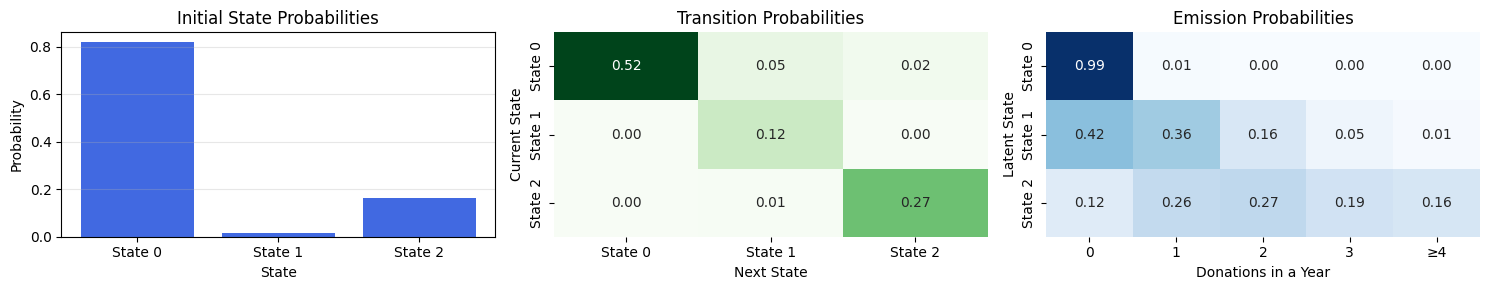

In [96]:
plot_hmm_params(
    transitions=A_norm,
    initial_probs=pi_norm,
    emissions=build_emission_matrix_truncated_poisson(rates_norm, max_k=4),
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

### Geometric

In this section, we use a Geometric distribution for the emission probabilities instead of a Poisson. Both distributions can model count data, but with different interpretations: the Poisson models the total number of events in a fixed period, while the Geometric models the number of trials until the first success.
However, in our dataset, the observed data are yearly donation counts ranging from 0 to 4. Using a Geometric emission can provide a different latent structure compared to the Poisson, but it is less natural for bounded count data, since the Geometric is unbounded above. This choice mainly affects how the HMM explains the observed counts and the interpretation of the latent states.

In [74]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam

def model(observations):
    N, T = observations.shape
    num_states = 3

    pi = pyro.sample("pi", dist.Dirichlet(torch.ones(num_states)))
    A = pyro.sample("A", dist.Dirichlet(torch.ones(num_states, num_states)).to_event(1))
    probs = pyro.sample("probs", dist.Beta(2.0 * torch.ones(num_states), torch.ones(num_states)).to_event(1))

    with pyro.plate("donors", N):
        x = pyro.sample("PD_0", dist.Categorical(pi), infer={"enumerate": "parallel"})
        for t in pyro.markov(range(T)):
            x = pyro.sample(f"PD_{t+1}", dist.Categorical(A[x]), infer={"enumerate": "parallel"})
            pyro.sample(f"y_{t}", dist.Geometric(probs[x]), obs=observations[:, t])

def guide(observations):
    num_states = 3
    pi_alpha = pyro.param("pi_alpha", torch.ones(num_states), constraint=dist.constraints.positive)
    A_alpha = pyro.param("A_alpha", torch.ones(num_states, num_states), constraint=dist.constraints.positive)
    probs_alpha = pyro.param("probs_alpha", 2.0 * torch.ones(num_states), constraint=dist.constraints.positive)
    probs_beta = pyro.param("probs_beta", torch.ones(num_states), constraint=dist.constraints.positive)

    pyro.sample("pi", dist.Dirichlet(pi_alpha))
    pyro.sample("A", dist.Dirichlet(A_alpha).to_event(1))
    pyro.sample("probs", dist.Beta(probs_alpha, probs_beta).to_event(1))

pyro.clear_param_store()  # resetta tutti i parametri!

optimizer = Adam({"lr": 0.01})
svi = SVI(model, guide, optimizer, loss=TraceEnum_ELBO(max_plate_nesting=1))

# pyro.render_model(model, model_args=(obs_torch,), render_distributions=False)


for step in range(200):
    loss = svi.step(obs_torch)
    if step % 20 == 0:
        print(f"Step {step} loss: {loss}")

Step 0 loss: 184404.6875
Step 20 loss: 188931.78125
Step 40 loss: 179021.328125
Step 60 loss: 184370.75
Step 80 loss: 173592.125
Step 100 loss: 182879.21875
Step 120 loss: 169128.953125
Step 140 loss: 165297.546875
Step 160 loss: 178771.015625
Step 180 loss: 176695.28125


In [77]:
learned_pi = pyro.param("pi_alpha").detach().cpu().numpy()
learned_A = pyro.param("A_alpha").detach().cpu().numpy()
learned_rates_alpha = pyro.param("probs_alpha").detach().cpu().numpy()
learned_rates_beta = pyro.param("probs_beta").detach().cpu().numpy()


pi_norm = learned_pi / learned_pi.sum()
A_norm = learned_A / learned_A.sum()
rates_norm = learned_rates_alpha / learned_rates_beta

print("Initial state probabilities (normalized):", pi_norm)
print("Transition matrix (normalized):", A_norm)
print("Poisson rates:", rates_norm)

Initial state probabilities (normalized): [0.43575013 0.34304374 0.22120614]
Transition matrix (normalized): [[0.2087608  0.05874154 0.05311325]
 [0.0592472  0.22135285 0.05607066]
 [0.05352712 0.05718495 0.23200162]]
Poisson rates: [1.5890595 1.4649932 1.2233624]


Most people start in state 2, which is expected since some individuals begin donating later or were not eligible to donate due to their age. The transition matrix shows that individuals in state 2 tend to move to state 0 or 1. Once they reach state 0 or 1, donors tend to maintain their donation behavior. State 1 appears to be the most populated, likely representing occasional donors, while state 0 can be interpreted as the state of frequent donors.

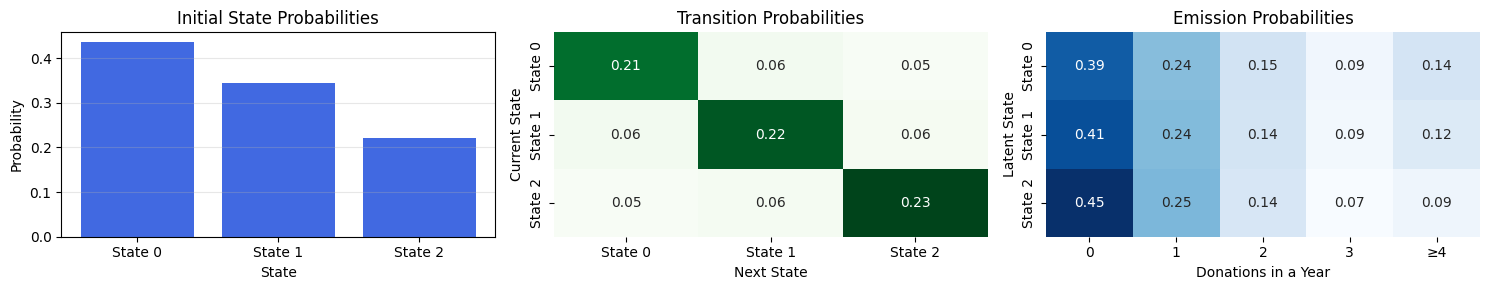

In [78]:
import numpy as np
from scipy.stats import geom

def build_emission_matrix_truncated_geometric(rates, max_k=4):
    S = len(rates)
    K = max_k + 1  # da 0 a 4, 5 valori
    ps = 1 / (rates + 1)
    emissions = np.zeros((S, K))
    for s in range(S):
        # Geometric shiftata: geom.pmf(k+1, p)
        for k in range(max_k):
            emissions[s, k] = geom.pmf(k+1, ps[s])
        # L'ultimo raccoglie tutta la coda: P(y >= max_k)
        emissions[s, max_k] = 1 - geom.cdf(max_k, ps[s])
    return emissions

emissions_matrix = build_emission_matrix_truncated_geometric(rates_norm, max_k=4)

plot_hmm_params(
    transitions=A_norm,
    initial_probs=pi_norm,
    emissions=emissions_matrix,
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

## Models with covariates

### Mixed Model

This is not any more a HMM but is a mixture model where each units has only one latent variable

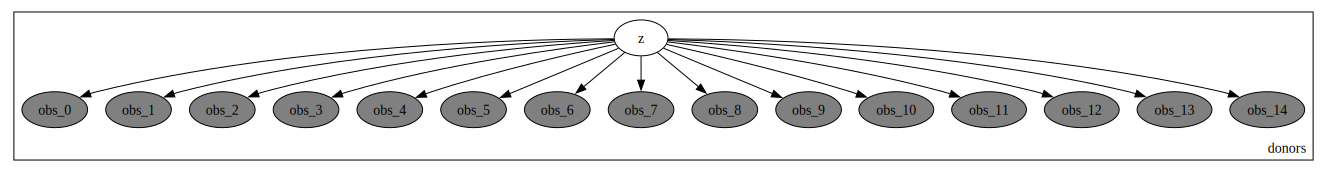

In [ ]:
import torch
import pyro
import pyro.distributions as dist
from pyro.nn import PyroSample, PyroModule
import pyro.distributions.constraints as constraints

def model(observations, donors_covariates):
    N, T = observations.shape
    K = 3  # numero di stati latenti
    
    with pyro.plate("latent_params", K):
        rate = pyro.param("rate", torch.ones(K), constraint=constraints.positive)  # emission rate per stato
    
    # Probs statici per gli stati latenti (es: uniforme o funzione delle covariate)
    if donors_covariates is not None:
        C = donors_covariates.shape[2]
        W0 = pyro.param("W0", torch.zeros(K, C))
        logits = torch.matmul(donors_covariates[:, 0, :], W0.T)  # [N, K]
        probs = torch.softmax(logits, dim=-1)
    else:
        probs = torch.ones(N, K) / K

    with pyro.plate("donors", N):
        z = pyro.sample("z", dist.Categorical(probs=probs))  # stato latente per ciascun individuo

        for t in range(T):
            lam = rate[z]  # emission rate Poisson, shape: (N,)
            pyro.sample(f"obs_{t}", dist.Poisson(lam), obs=observations[:, t])

def guide(observations, donors_covariates):
    N, T = observations.shape
    K = 3

    q_logits = pyro.param("q_logits", torch.zeros(N, K))
    with pyro.plate("donors", N):
        pyro.sample("z", dist.Categorical(logits=q_logits))

pyro.render_model(model, model_args=(obs_torch, covariates_torch), render_distributions=False)

In [122]:
from pyro.optim import ClippedAdam
from pyro.infer import SVI, Trace_ELBO
# Assumendo: observations_torch (N, T) e covariates_torch (N, C) siano tensor torch
pyro.clear_param_store()

optimizer = ClippedAdam({"lr": 0.1})
elbo = Trace_ELBO()
svi = SVI(model, guide, optimizer, loss=elbo)

n_steps = 2000
for step in range(n_steps):
    loss = svi.step(obs_torch, covariates_torch)
    if step % 200 == 0:
        print(f"[{step}] Loss = {loss:.2f}")


[0] Loss = 177716.08
[200] Loss = 175650.32
[400] Loss = 175930.54
[600] Loss = 175535.65
[800] Loss = 171900.61
[1000] Loss = 167620.52
[1200] Loss = 166147.14
[1400] Loss = 166337.93
[1600] Loss = 166518.26
[1800] Loss = 165351.33


Probabilità iniziali (media popolazione): [0.6300041  0.18188497 0.18811637]
Rate Poisson per stato: [0.48586363 1.2853053  1.2303791 ]
Matrice di transizione (identità):
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


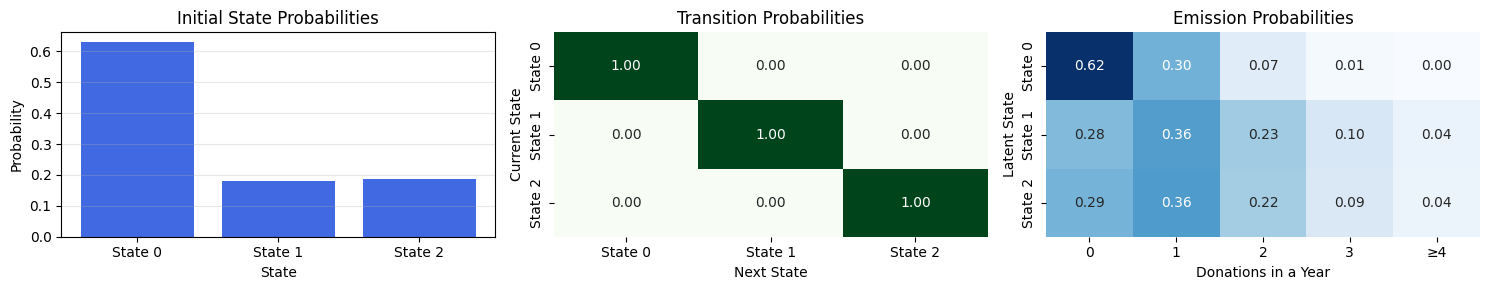

In [123]:
import numpy as np

# Estrai i parametri stimati
rate = pyro.param("rate").detach().cpu().numpy()  # [K]
W0 = pyro.param("W0").detach().cpu().numpy()      # [K, C]

# Calcola le probabilità iniziali medie sulla popolazione
logits = np.matmul(covariates_torch[:, 0, :].cpu().numpy(), W0.T)  # [N, K]
probs = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)
init_probs = probs.mean(axis=0)  # media sulle N persone

# Nessuna matrice di transizione in questo modello, puoi usare una matrice identità o None
transitions = np.eye(rate.shape[0])

# Costruisci la matrice di emissione Poisson come prima
def build_emission_matrix_truncated_poisson(rates, max_k=4):
    from scipy.stats import poisson
    S = len(rates)
    K = max_k + 1
    emissions = np.zeros((S, K))
    for s in range(S):
        for k in range(max_k):
            emissions[s, k] = poisson.pmf(k, rates[s])
        emissions[s, max_k] = 1 - poisson.cdf(max_k-1, rates[s])
    return emissions

emissions_matrix = build_emission_matrix_truncated_poisson(rate, max_k=4)

# Stampa i risultati numerici
print("Probabilità iniziali (media popolazione):", init_probs)
print("Rate Poisson per stato:", rate)
print("Matrice di transizione (identità):\n", transitions)

# Visualizza il grafico
plot_hmm_params(
    transitions=transitions,
    initial_probs=init_probs,
    emissions=emissions_matrix,
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

### Static Covariates

#### Poisson

In [168]:
def model(observations, donors_covariates):
    N, T = observations.shape
    K = 3
    C = donors_covariates.shape[2]

    # Parametri emissioni
    rate = pyro.param("rate", torch.ones(K), constraint=constraints.positive)
    # Parametri iniziali
    init_logits = pyro.param("init_logits", torch.zeros(K))
    # Parametri transizione
    trans_W = pyro.param("trans_W", torch.zeros(K, K, C))
    trans_b = pyro.param("trans_b", torch.zeros(K, K))

    with pyro.plate("donors", N):
        # Stato iniziale
        z_prev = pyro.sample(
            "z_0", dist.Categorical(logits=init_logits)
        )
        lam = rate[z_prev]
        pyro.sample("obs_0", dist.Poisson(lam), obs=observations[:, 0])

        # vectorized
        for t in range(1, T):
            trans_W_zprev = trans_W[z_prev]           # (N, K, C)
            trans_b_zprev = trans_b[z_prev]           # (N, K)
            covs = donors_covariates[:, t, :]         # (N, C)
            logits = (trans_W_zprev * covs[:, None, :]).sum(-1) + trans_b_zprev  # (N, K)
            z_t = pyro.sample(f"z_{t}", dist.Categorical(logits=logits))
            lam = rate[z_t]
            pyro.sample(f"obs_{t}", dist.Poisson(lam), obs=observations[:, t])
            z_prev = z_t
        
        # nested loop version (commentata perché non necessaria)
        # for t in range(1, T):
        #     logits = []
        #     for i in range(N):
        #         l = trans_b[z_prev[i]] + (trans_W[z_prev[i]] @ donors_covariates[i, t, :])
        #         logits.append(l)
        #     logits = torch.stack(logits)  # (N, K)
        #     z_t = pyro.sample(
        #         f"z_{t}", dist.Categorical(logits=logits)
        #     )
        #     lam = rate[z_t]
        #     pyro.sample(f"obs_{t}", dist.Poisson(lam), obs=observations[:, t])
        #     z_prev = z_t

def guide(observations, donors_covariates):
    # Mean field: lasciamo che Pyro gestisca tutto
    pass

# pyro.render_model(model, model_args=(obs_torch, covariates_torch), render_distributions=False)

In [169]:
pyro.clear_param_store()  # resetta tutti i parametri!
optimizer = Adam({"lr": 0.1})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, guide, optimizer, loss=elbo)
n_steps = 250
for step in range(n_steps):
    loss = svi.step(obs_torch, covariates_torch)
    if step % 20 == 0:
        print(f"[{step}] Loss = {loss:.2f}")


c:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\util.py:303: UserWarning: Found vars in model but not guide: {'z_7', 'z_6', 'z_10', 'z_12', 'z_14', 'z_2', 'z_9', 'z_13', 'z_1', 'z_5', 'z_11', 'z_3', 'z_8', 'z_0', 'z_4'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
c:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\infer\traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(


[0] Loss = 329918.34
[20] Loss = 262708.88
[40] Loss = 265320.06
[60] Loss = 261429.67
[80] Loss = 249838.16
[100] Loss = 231578.27
[120] Loss = 221444.86
[140] Loss = 215030.03
[160] Loss = 212906.47
[180] Loss = 214393.88
[200] Loss = 215243.36
[220] Loss = 199680.95
[240] Loss = 210857.72


Probabilità iniziali (media popolazione): [0.27551726 0.3232657  0.40121704]
Rate Poisson per stato: [0.37749434 0.687364   0.88138455]
Matrice di transizione (media sulle covariate):
 [[0.00925367 0.11891323 0.87183309]
 [0.79126012 0.09975785 0.10898209]
 [0.01216889 0.00797684 0.97985423]]


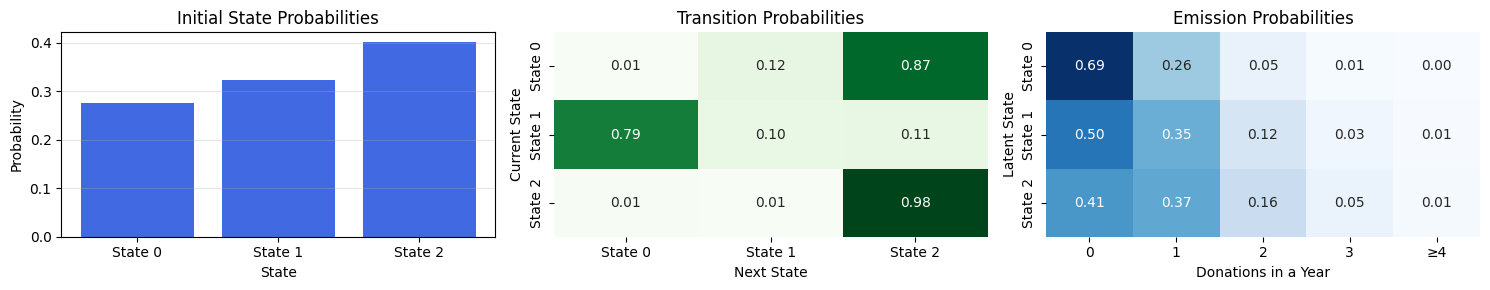

In [170]:
rate = pyro.param("rate").detach().cpu().numpy()  # [K]

K, C = pyro.param("trans_W").shape[-2:]
trans_W = pyro.param("trans_W").detach().cpu().numpy()  # [K, K, C]
trans_b = pyro.param("trans_b").detach().cpu().numpy()  # [K, K]
covs = covariates_torch.cpu().numpy()                   # [N, T, C]

covs_mean = covs[:, 0, :].mean(axis=0)  # [C]

transitions = np.zeros((K, K))
for prev in range(K):
    logits = trans_b[prev] + trans_W[prev] @ covs_mean  # [K]
    probs = np.exp(logits) / np.exp(logits).sum()
    transitions[prev, :] = probs

emissions_matrix = build_emission_matrix_truncated_poisson(rate, max_k=4)

print("Probabilità iniziali (media popolazione):", init_probs)
print("Rate Poisson per stato:", rate)
print("Matrice di transizione (media sulle covariate):\n", transitions)


plot_hmm_params(
    transitions=transitions,
    initial_probs=init_probs,
    emissions=emissions_matrix,
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

#### Negative Binomial

In [171]:
import torch
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

def model(observations, donors_covariates):
    N, T = observations.shape
    K = 3
    C = donors_covariates.shape[2]

    # Parametri emissioni per stato: total_count e prob
    total_count = pyro.param("total_count", torch.ones(K), constraint=constraints.positive)
    logits = pyro.param("emiss_logits", torch.zeros(K))  # per la prob: prob = sigmoid(logits)

    # Parametri iniziali
    init_logits = pyro.param("init_logits", torch.zeros(K))
    # Parametri transizione
    trans_W = pyro.param("trans_W", torch.zeros(K, K, C))
    trans_b = pyro.param("trans_b", torch.zeros(K, K))

    with pyro.plate("donors", N):
        # Stato iniziale
        z_prev = pyro.sample(
            "z_0", dist.Categorical(logits=init_logits)
        )
        # Emissione iniziale: NB
        nb_total = total_count[z_prev]
        nb_prob = torch.sigmoid(logits[z_prev])
        pyro.sample("obs_0", dist.NegativeBinomial(total_count=nb_total, probs=nb_prob), obs=observations[:, 0])

        for t in range(1, T):
            trans_W_zprev = trans_W[z_prev]           # (N, K, C)
            trans_b_zprev = trans_b[z_prev]           # (N, K)
            covs = donors_covariates[:, t, :]         # (N, C)
            trans_logits = (trans_W_zprev * covs[:, None, :]).sum(-1) + trans_b_zprev  # (N, K)
            z_t = pyro.sample(f"z_{t}", dist.Categorical(logits=trans_logits))
            # Emissione Negative Binomial
            nb_total = total_count[z_t]
            nb_prob = torch.sigmoid(logits[z_t])
            pyro.sample(f"obs_{t}", dist.NegativeBinomial(total_count=nb_total, probs=nb_prob), obs=observations[:, t])
            z_prev = z_t

def guide(observations, donors_covariates):
    # Mean field: lasciamo che Pyro gestisca tutto
    pass

In [173]:
pyro.clear_param_store()
optimizer = Adam({"lr": 0.1})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, guide, optimizer, loss=elbo)
n_steps = 250
for step in range(n_steps):
    loss = svi.step(obs_torch, covariates_torch)
    if step % 20 == 0:
        print(f"[{step}] Loss = {loss:.2f}")


c:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\util.py:303: UserWarning: Found vars in model but not guide: {'z_7', 'z_6', 'z_10', 'z_12', 'z_14', 'z_2', 'z_9', 'z_13', 'z_1', 'z_5', 'z_11', 'z_3', 'z_8', 'z_0', 'z_4'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
c:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\infer\traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(


[0] Loss = 321653.69
[20] Loss = 266592.34
[40] Loss = 248170.31
[60] Loss = 238584.98
[80] Loss = 218330.84
[100] Loss = 211781.50
[120] Loss = 217666.92
[140] Loss = 209700.84
[160] Loss = 202118.95
[180] Loss = 202136.69
[200] Loss = 201947.77
[220] Loss = 198599.94
[240] Loss = 197290.34


In [149]:
# Recupera i valori ottimizzati
total_count = pyro.param("total_count").detach().cpu().numpy()   # shape (K,)
emiss_logits = pyro.param("emiss_logits").detach().cpu().numpy() # shape (K,)
probs = 1 / (1 + np.exp(-emiss_logits))  # sigmoid

print("Rate Negative Binomial per stato:")
for k in range(len(total_count)):
    print(f"  Stato {k}: total_count = {total_count[k]:.3f}, prob = {probs[k]:.3f}")

Rate Negative Binomial per stato:
  Stato 0: total_count = 0.446, prob = 0.575
  Stato 1: total_count = 2.851, prob = 0.264
  Stato 2: total_count = 0.658, prob = 0.418


In [174]:
means = total_count * (1 - probs) / probs
print("Media Negative Binomial per stato:")
for k in range(len(total_count)):
    print(f"  Stato {k}: mean = {means[k]:.3f}")

Media Negative Binomial per stato:
  Stato 0: mean = 89.533
  Stato 1: mean = 166.305
  Stato 2: mean = 0.021


Probabilità iniziali (media popolazione): [0.9904486  0.00761377 0.00193762]
Negative Binomial total_count per stato: [1.3831676  0.85466516 3.127574  ]
Negative Binomial probs per stato: [0.38206324 0.3866115  0.20782936]
Matrice di transizione (media sulle covariate):
 [[0.01391127 0.98038477 0.00570392]
 [0.94811708 0.0134943  0.03838864]
 [0.21819013 0.74931121 0.03249869]]


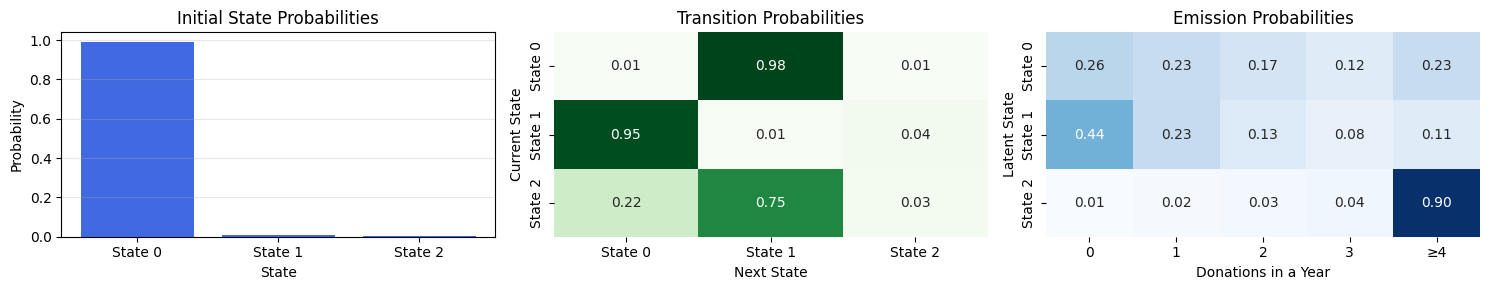

In [175]:
import numpy as np

# 1. Estrai i parametri stimati
total_count = pyro.param("total_count").detach().cpu().numpy()    # [K]
emiss_logits = pyro.param("emiss_logits").detach().cpu().numpy()  # [K]
probs = 1 / (1 + np.exp(-emiss_logits))                          # [K]

# Iniziali: come nel tuo esempio, se hai parametri per la dipendenza dalle covariate:
# init_W = pyro.param("init_W").detach().cpu().numpy()  # [K, C]
# init_b = pyro.param("init_b").detach().cpu().numpy()  # [K]
# covs_0 = covariates_torch[:, 0, :].cpu().numpy()      # [N, C]
# logits = covs_0 @ init_W.T + init_b                   # [N, K]
# probs_init = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)  # [N, K]
# init_probs = probs_init.mean(axis=0)                  # [K]

# Se invece hai solo logits iniziali:
init_logits = pyro.param("init_logits").detach().cpu().numpy()  # [K]
init_probs = np.exp(init_logits) / np.exp(init_logits).sum()    # [K]

K, C = pyro.param("trans_W").shape[-2:]
trans_W = pyro.param("trans_W").detach().cpu().numpy()  # [K, K, C]
trans_b = pyro.param("trans_b").detach().cpu().numpy()  # [K, K]
covs = covariates_torch.cpu().numpy()                   # [N, T, C]

# Media sulle covariate del primo anno
covs_mean = covs[:, 0, :].mean(axis=0)  # [C]

# Matrice di transizione media per ogni stato
transitions = np.zeros((K, K))
for prev in range(K):
    logits = trans_b[prev] + trans_W[prev] @ covs_mean  # [K]
    probs_tr = np.exp(logits) / np.exp(logits).sum()
    transitions[prev, :] = probs_tr

# Costruisci la matrice di emissione Negative Binomial (truncated)
def build_emission_matrix_truncated_nbinom(total_count, probs, max_k=4):
    from scipy.stats import nbinom
    S = len(total_count)
    K = max_k + 1
    emissions = np.zeros((S, K))
    for s in range(S):
        for k in range(max_k):
            emissions[s, k] = nbinom.pmf(k, total_count[s], probs[s])
        emissions[s, max_k] = 1 - nbinom.cdf(max_k-1, total_count[s], probs[s])
    return emissions

emissions_matrix = build_emission_matrix_truncated_nbinom(total_count, probs, max_k=4)

# Stampa i risultati numerici
print("Probabilità iniziali (media popolazione):", init_probs)
print("Negative Binomial total_count per stato:", total_count)
print("Negative Binomial probs per stato:", probs)
print("Matrice di transizione (media sulle covariate):\n", transitions)

plot_hmm_params(
    transitions=transitions,
    initial_probs=init_probs,
    emissions=emissions_matrix,
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

In [176]:
import pandas as pd
rows = []
for i in range(K):
    for j in range(K):
        for c, name in enumerate(['birth_year_norm', 'gender_code']):
            rows.append({'from': i, 'to': j, 'covariate': name, 'weight': trans_W[i,j,c]})
df = pd.DataFrame(rows)
print(df.pivot_table(index=['from', 'to'], columns='covariate', values='weight'))

covariate  birth_year_norm  gender_code
from to                                
0    0           -1.488027    -1.384053
     1            1.543767     2.451682
     2           -0.271251    -1.251682
1    0            2.058189     0.651762
     1            0.064207    -1.294049
     2           -2.525017     0.226052
2    0           -2.456770     1.210996
     1            1.710090     0.435225
     2            0.416191    -1.113018


### Dynamic Covariates

#### Negative Binomial

In [230]:
def model(observations, donors_covariates):
    N, T = observations.shape
    K = 4
    C = donors_covariates.shape[2]

    # Parametri emissioni per stato: total_count e prob
    total_count = pyro.param("total_count", torch.ones(K), constraint=constraints.positive)
    logits = pyro.param("emiss_logits", torch.zeros(K))  # per la prob: prob = sigmoid(logits)

    # Parametri iniziali
    init_logits = pyro.param("init_logits", torch.zeros(K))
    # Parametri transizione
    trans_W = pyro.param("trans_W", torch.zeros(K, K, C))
    trans_b = pyro.param("trans_b", torch.zeros(K, K))

    with pyro.plate("donors", N):
        # Stato iniziale
        z_prev = pyro.sample(
            "z_0", dist.Categorical(logits=init_logits)
        )
        # Emissione iniziale: NB
        nb_total = total_count[z_prev]
        nb_prob = torch.sigmoid(logits[z_prev])
        pyro.sample("obs_0", dist.NegativeBinomial(total_count=nb_total, probs=nb_prob), obs=observations[:, 0])

        for t in range(1, T):
            trans_W_zprev = trans_W[z_prev]           # (N, K, C)
            trans_b_zprev = trans_b[z_prev]           # (N, K)
            covs = donors_covariates[:, t, :]         # (N, C)
            trans_logits = (trans_W_zprev * covs[:, None, :]).sum(-1) + trans_b_zprev  # (N, K)
            z_t = pyro.sample(f"z_{t}", dist.Categorical(logits=trans_logits))
            # Emissione Negative Binomial
            nb_total = total_count[z_t]
            nb_prob = torch.sigmoid(logits[z_t])
            pyro.sample(f"obs_{t}", dist.NegativeBinomial(total_count=nb_total, probs=nb_prob), obs=observations[:, t])
            z_prev = z_t

def guide(observations, donors_covariates):
    # Mean field: lasciamo che Pyro gestisca tutto
    pass

In [ ]:
pyro.clear_param_store()
optimizer = Adam({"lr": 0.1, "weight_decay": 0.002})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, guide, optimizer, loss=elbo)

for step in range(250):
    loss = svi.step(obs_torch, full_covariates_torch)
    if step % 20 == 0:
        print(f"Step {step} : loss = {loss:.2f}")


c:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\util.py:303: UserWarning: Found vars in model but not guide: {'z_7', 'z_6', 'z_10', 'z_12', 'z_14', 'z_2', 'z_9', 'z_13', 'z_1', 'z_5', 'z_11', 'z_3', 'z_8', 'z_0', 'z_4'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
c:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\infer\traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(


Step 0 : loss = 361508.38
Step 20 : loss = 265030.25
Step 40 : loss = 208731.92
Step 60 : loss = 200627.28
Step 80 : loss = 196673.50
Step 100 : loss = 194025.27
Step 120 : loss = 191389.31
Step 140 : loss = 191494.77
Step 160 : loss = 191401.03
Step 180 : loss = 193502.12
Step 200 : loss = 187672.70
Step 220 : loss = 185150.16
Step 240 : loss = 179332.69


Rate Negative Binomial per stato:
  Stato 0: total_count = 3.838, prob = 0.218
  Stato 1: total_count = 0.657, prob = 0.415
  Stato 2: total_count = 1.293, prob = 0.311
  Stato 3: total_count = 0.402, prob = 0.594
Probabilità iniziali (media popolazione): [0.00741461 0.01963824 0.00757392 0.9653733 ]
Negative Binomial total_count per stato: [3.8376336  0.65730196 1.2931429  0.4015798 ]
Negative Binomial probs per stato: [0.21819381 0.41533354 0.31118768 0.5939331 ]
Matrice di transizione (media sulle covariate):
 [[0.65895188 0.1922119  0.04822942 0.10060677]
 [0.00352736 0.96051508 0.01819062 0.01776692]
 [0.41417781 0.02157459 0.51702493 0.04722267]
 [0.03130704 0.5821591  0.03977236 0.34676155]]


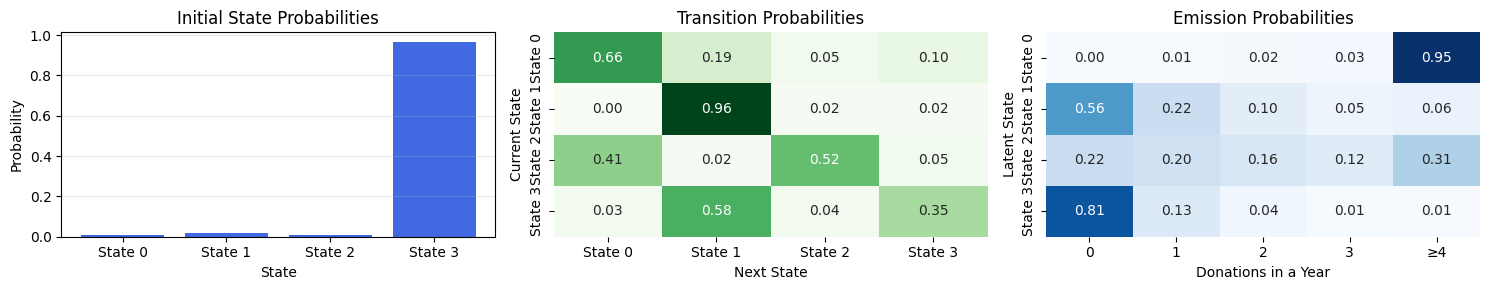

In [232]:
import numpy as np

# Recupera i valori ottimizzati
total_count = pyro.param("total_count").detach().cpu().numpy()   # shape (K,)
emiss_logits = pyro.param("emiss_logits").detach().cpu().numpy() # shape (K,)
probs = 1 / (1 + np.exp(-emiss_logits))  # sigmoid

print("Rate Negative Binomial per stato:")
for k in range(len(total_count)):
    print(f"  Stato {k}: total_count = {total_count[k]:.3f}, prob = {probs[k]:.3f}")
init_logits = pyro.param("init_logits").detach().cpu().numpy()  # [K]
init_probs = np.exp(init_logits) / np.exp(init_logits).sum()    # [K]

K, C = pyro.param("trans_W").shape[-2:]
trans_W = pyro.param("trans_W").detach().cpu().numpy()  # [K, K, C]
trans_b = pyro.param("trans_b").detach().cpu().numpy()  # [K, K]
covs = full_covariates_torch.cpu().numpy()                   # [N, T, C]

# Media sulle covariate del primo anno
covs_mean = covs[:, 0, :].mean(axis=0)  # [C]

# Matrice di transizione media per ogni stato
transitions = np.zeros((K, K))
for prev in range(K):
    logits = trans_b[prev] + trans_W[prev] @ covs_mean  # [K]
    probs_tr = np.exp(logits) / np.exp(logits).sum()
    transitions[prev, :] = probs_tr

# Costruisci la matrice di emissione Negative Binomial (truncated)
def build_emission_matrix_truncated_nbinom(total_count, probs, max_k=4):
    from scipy.stats import nbinom
    S = len(total_count)
    K = max_k + 1
    emissions = np.zeros((S, K))
    for s in range(S):
        for k in range(max_k):
            emissions[s, k] = nbinom.pmf(k, total_count[s], probs[s])
        emissions[s, max_k] = 1 - nbinom.cdf(max_k-1, total_count[s], probs[s])
    return emissions

emissions_matrix = build_emission_matrix_truncated_nbinom(total_count, probs, max_k=4)

# Stampa i risultati numerici
print("Probabilità iniziali (media popolazione):", init_probs)
print("Negative Binomial total_count per stato:", total_count)
print("Negative Binomial probs per stato:", probs)
print("Matrice di transizione (media sulle covariate):\n", transitions)

plot_hmm_params(
    transitions=transitions,
    initial_probs=init_probs,
    emissions=emissions_matrix,
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

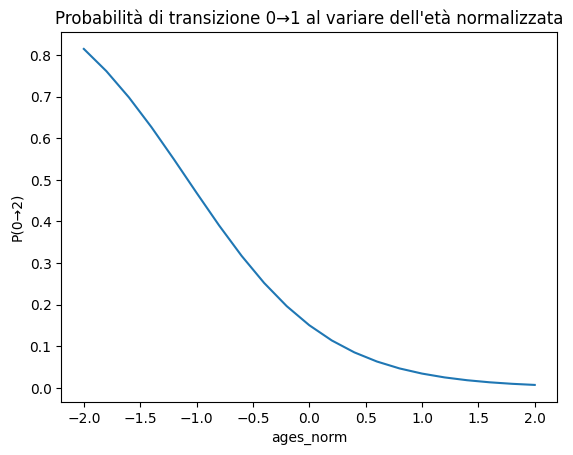

In [228]:
import numpy as np

# Esempio per 'ages_norm'
ages_range = np.linspace(-2, 2, 21)  # da molto giovani a molto anziani (normalizzato)
covs_mean = full_covariates.mean(axis=(0,1))  # [C]
matrici = []

for age in ages_range:
    x = covs_mean.copy()
    x[2] = age  # supponiamo ages_norm sia la terza covariata
    trans_matrices = []
    for prev in range(K):
        logits = trans_b[prev] + trans_W[prev] @ x
        probs_tr = np.exp(logits) / np.exp(logits).sum()
        trans_matrices.append(probs_tr)
    matrici.append(np.array(trans_matrices))  # shape (K, K)

# Ad esempio: transizione dallo stato 0 a 2 in funzione dell'età
plt.plot(ages_range, [mat[0,1] for mat in matrici])
plt.xlabel("ages_norm")
plt.ylabel("P(0→2)")
plt.title("Probabilità di transizione 0→1 al variare dell'età normalizzata")
plt.show()

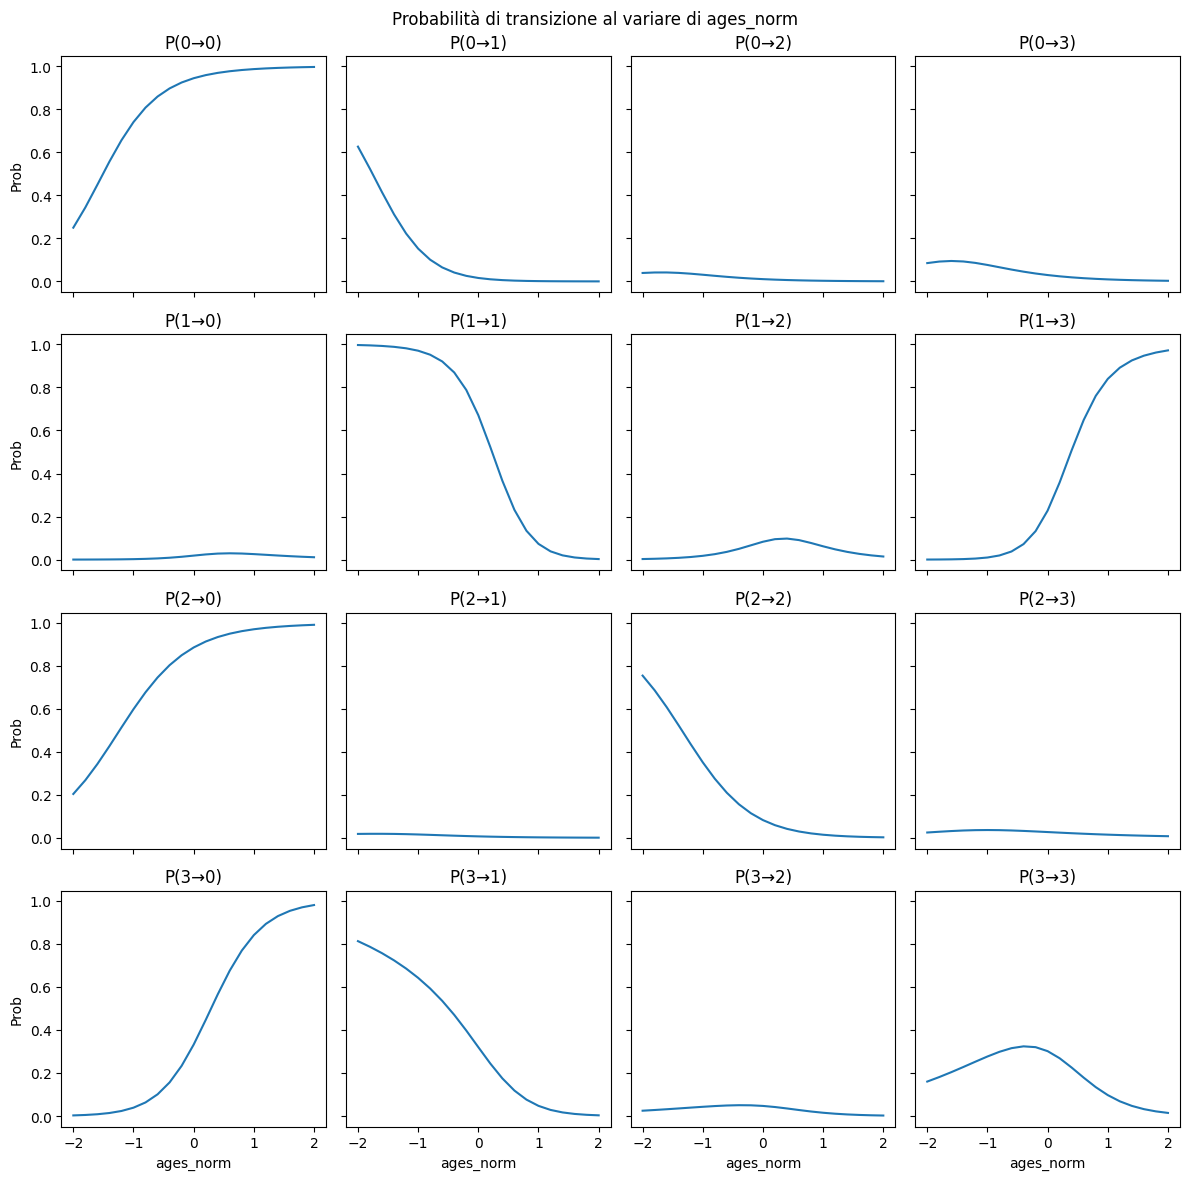

In [234]:
import numpy as np
import matplotlib.pyplot as plt

K = trans_b.shape[0]  # Numero di stati
C = trans_W.shape[2]  # Numero di covariate

ages_range = np.linspace(-2, 2, 21)
covs_mean = full_covariates.mean(axis=(0,1))  # [C]
matrici = []

for age in ages_range:
    x = covs_mean.copy()
    # supponiamo ages_norm sia la covariata indice idx_age
    idx_age = 2  # cambialo se ages_norm non è la terza!
    x[idx_age] = age
    trans_matrices = []
    for prev in range(K):
        logits = trans_b[prev] + trans_W[prev] @ x
        probs_tr = np.exp(logits) / np.exp(logits).sum()
        trans_matrices.append(probs_tr)
    matrici.append(np.array(trans_matrices))  # shape (K, K)

matrici = np.array(matrici)  # shape (len(ages_range), K, K)

# Plot a griglia: ogni subplot è la transizione da i a j
fig, axes = plt.subplots(K, K, figsize=(K*3, K*3), sharex=True, sharey=True)
for i in range(K):
    for j in range(K):
        axes[i, j].plot(ages_range, matrici[:, i, j])
        axes[i, j].set_title(f'P({i}→{j})')
        if i == K-1:
            axes[i, j].set_xlabel('ages_norm')
        if j == 0:
            axes[i, j].set_ylabel('Prob')
plt.suptitle('Probabilità di transizione al variare di ages_norm')
plt.tight_layout()
plt.show()

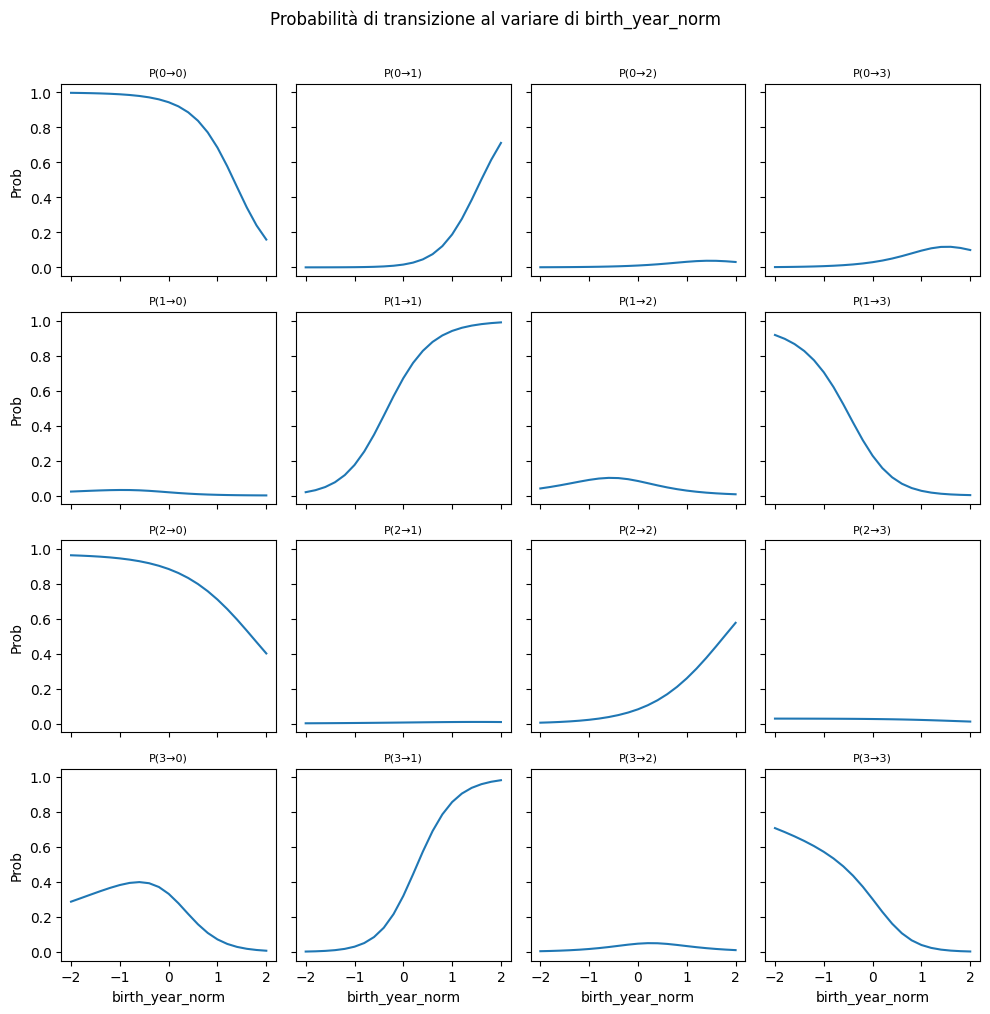

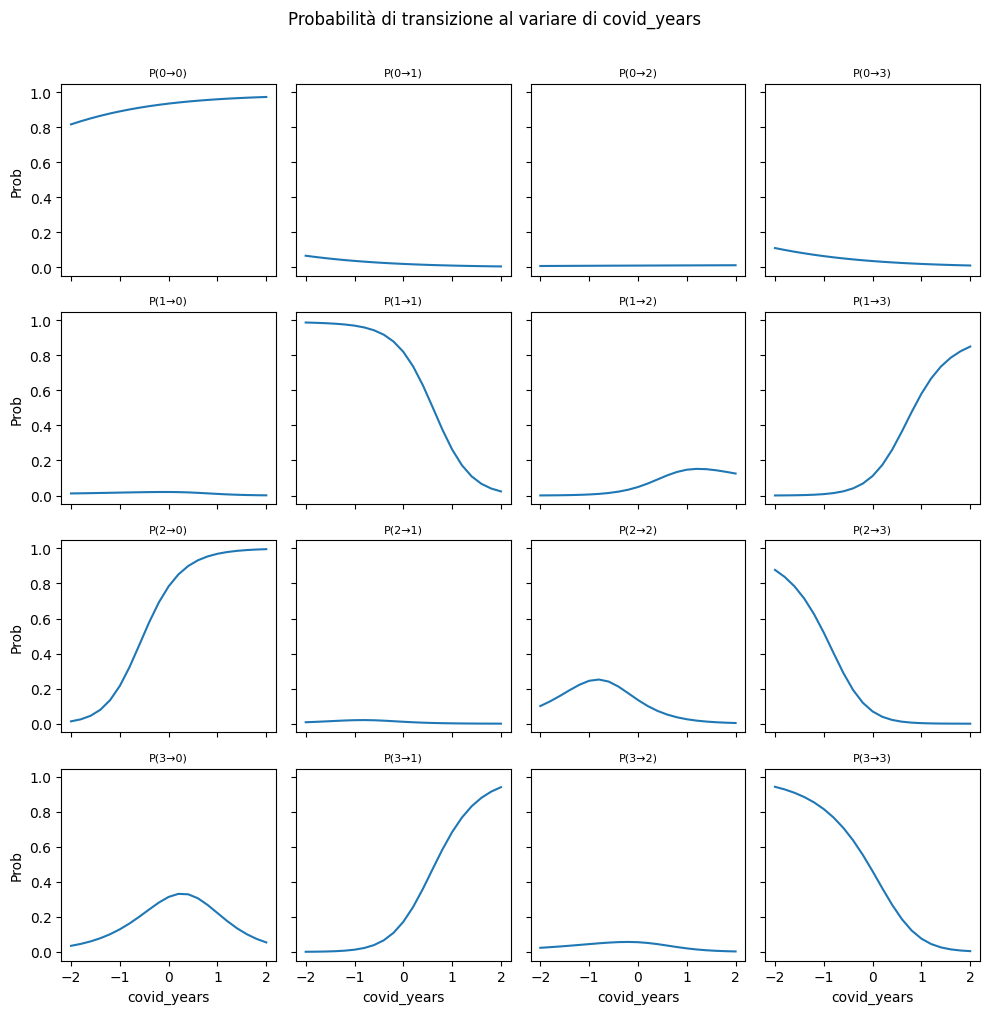

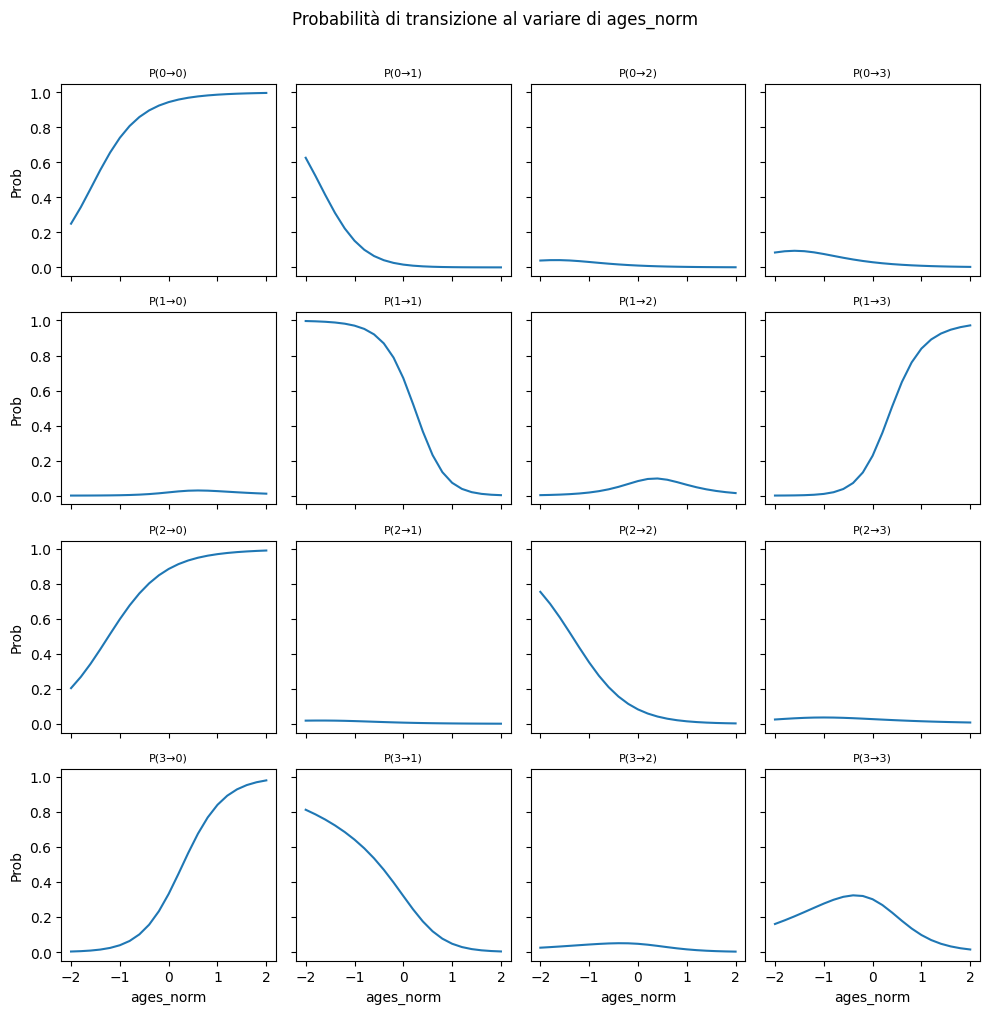

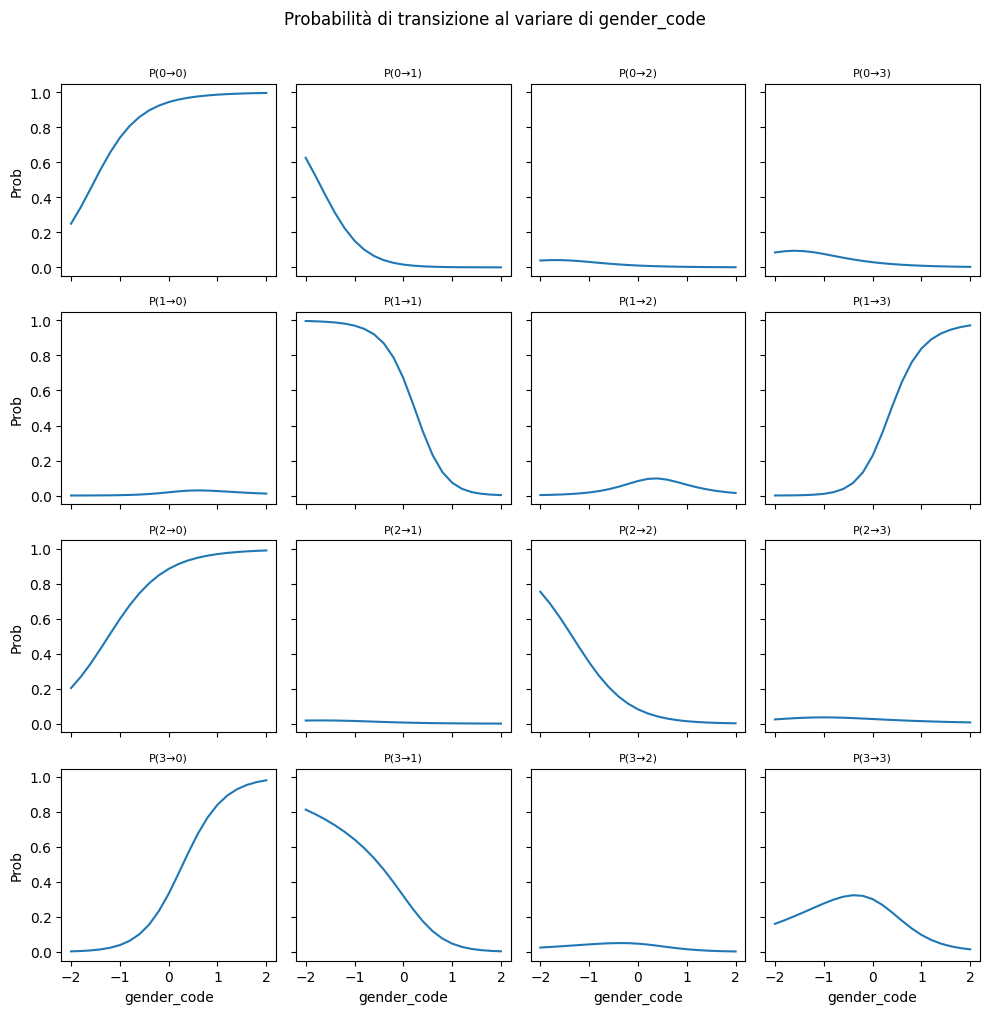

In [235]:
import numpy as np
import matplotlib.pyplot as plt

def plot_transition_grid(var_name, covariate_names, trans_b, trans_W, full_covariates, grid_vals=None):
    """
    var_name: string, nome della covariata da variare (es: 'ages_norm')
    covariate_names: lista di nomi delle covariate (es: ['a', 'b', 'ages_norm', ...])
    trans_b, trans_W: parametri di transizione
    full_covariates: array [N, T, C], per calcolare le medie
    grid_vals: opzionale, valori su cui variare la covariata (default: linspace(-2, 2, 21))
    """
    K = trans_b.shape[0]
    C = trans_W.shape[2]
    idx = covariate_names.index(var_name)
    if grid_vals is None:
        grid_vals = np.linspace(-2, 2, 21)
    covs_mean = full_covariates.mean(axis=(0,1))  # [C]
    matrici = []

    for v in grid_vals:
        x = covs_mean.copy()
        x[idx] = v
        trans_matrices = []
        for prev in range(K):
            logits = trans_b[prev] + trans_W[prev] @ x
            probs_tr = np.exp(logits) / np.exp(logits).sum()
            trans_matrices.append(probs_tr)
        matrici.append(np.array(trans_matrices))  # (K, K)

    matrici = np.array(matrici)  # (len(grid_vals), K, K)

    fig, axes = plt.subplots(K, K, figsize=(K*2.5, K*2.5), sharex=True, sharey=True)
    for i in range(K):
        for j in range(K):
            axes[i, j].plot(grid_vals, matrici[:, i, j])
            axes[i, j].set_title(f'P({i}→{j})', fontsize=8)
            if i == K-1:
                axes[i, j].set_xlabel(var_name)
            if j == 0:
                axes[i, j].set_ylabel('Prob')
    plt.suptitle(f'Probabilità di transizione al variare di {var_name}', y=1.01)
    plt.tight_layout()
    plt.show()


covariate_names = ['birth_year_norm', 'covid_years', 'ages_norm', 'gender_code']  # Adatta ai tuoi nomi reali!

for nome in covariate_names:
    plot_transition_grid(nome, covariate_names, trans_b, trans_W, full_covariates)

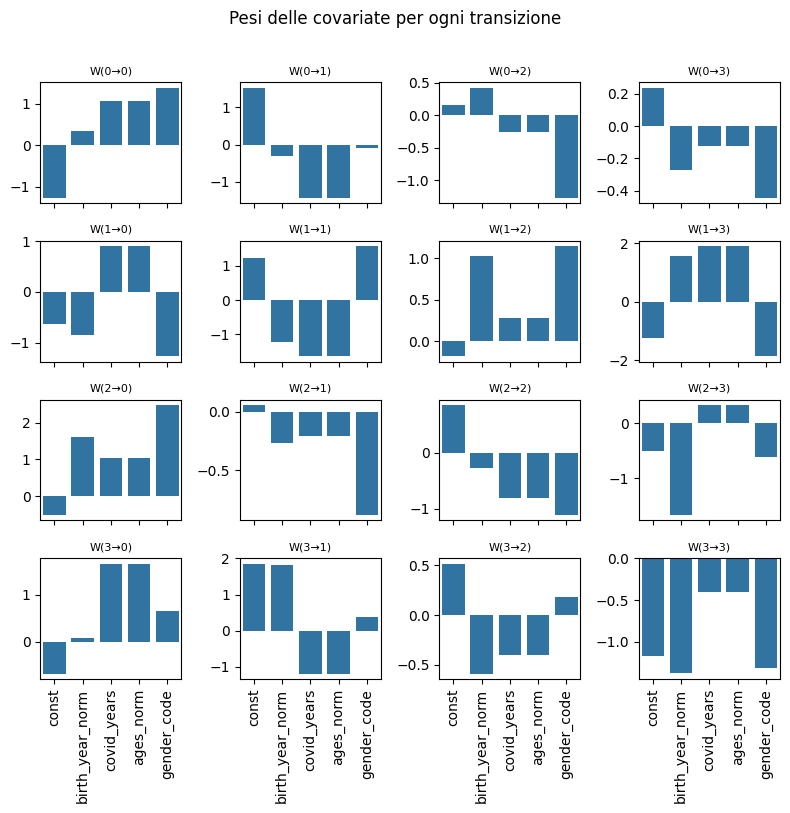

In [243]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_weights_grid(trans_W, covariate_names):
    K = trans_W.shape[0]
    C = trans_W.shape[2]

    fig, axes = plt.subplots(K, K, figsize=(K*2, K*2))
    for i in range(K):
        for j in range(K):
            sns.barplot(
                x=np.arange(C),
                y=trans_W[i, j],
                ax=axes[i, j]
            )
            axes[i, j].set_title(f'W({i}→{j})', fontsize=8)
            axes[i, j].set_xticks(np.arange(C))
            if i == K-1:
                axes[i, j].set_xticklabels(covariate_names, rotation=90)
            else:
                axes[i, j].set_xticklabels([])
    plt.suptitle('Pesi delle covariate per ogni transizione', y=1.01)
    plt.tight_layout()
    plt.show()


covariate_names = ['const', 'birth_year_norm', 'covid_years', 'ages_norm', 'gender_code']
plot_weights_grid(trans_W, covariate_names)

In [233]:
import pandas as pd
rows = []
for i in range(K):
    for j in range(K):
        for c, name in enumerate(['birth_year_norm', 'gender_code', 'ages_norm', 'covid_years']):
            rows.append({'from': i, 'to': j, 'covariate': name, 'weight': trans_W[i,j,c]})
df = pd.DataFrame(rows)
print(df.pivot_table(index=['from', 'to'], columns='covariate', values='weight'))

covariate  ages_norm  birth_year_norm  covid_years  gender_code
from to                                                        
0    0      1.069371        -1.259709     1.069371     0.357384
     1     -1.431240         1.530680    -1.431240    -0.318250
     2     -0.252525         0.165389    -0.252525     0.425597
     3     -0.124310         0.236623    -0.124310    -0.270538
1    0      0.898509        -0.640536     0.898508    -0.857738
     1     -1.637119         1.237935    -1.637119    -1.214546
     2      0.284038        -0.182194     0.284038     1.033329
     3      1.885502        -1.239294     1.885502     1.574515
2    0      1.024814        -0.513322     1.024814     1.619946
     1     -0.207357         0.057930    -0.207357    -0.269687
     2     -0.816754         0.855035    -0.816754    -0.262612
     3      0.331664        -0.512450     0.331664    -1.674762
3    0      1.657526        -0.672637     1.657526     0.080625
     1     -1.186754         1.850747   

#### Covariates on Tranistion matrix

In [ ]:
def model(observations, donors_covariates):
    N, T = observations.shape
    K = 4
    C = donors_covariates.shape[2]

    # Parametri emissioni per stato: total_count e prob
    total_count = pyro.param("total_count", torch.ones(K), constraint=constraints.positive)
    logits = pyro.param("emiss_logits", torch.zeros(K))  # per la prob: prob = sigmoid(logits)

    # Parametri iniziali
    init_logits = pyro.param("init_logits", torch.zeros(K))
    # Parametri transizione
    trans_W = pyro.param("trans_W", torch.zeros(K, K, C))
    trans_b = pyro.param("trans_b", torch.zeros(K, K))

    with pyro.plate("donors", N):
        # Stato iniziale
        z_prev = pyro.sample(
            "z_0", dist.Categorical(logits=init_logits)
        )
        # Emissione iniziale: NB
        nb_total = total_count[z_prev]
        nb_prob = torch.sigmoid(logits[z_prev])
        pyro.sample("obs_0", dist.NegativeBinomial(total_count=nb_total, probs=nb_prob), obs=observations[:, 0])

        for t in range(1, T):
            trans_W_zprev = trans_W[z_prev]           # (N, K, C)
            trans_b_zprev = trans_b[z_prev]           # (N, K)
            covs = donors_covariates[:, t, :]         # (N, C)
            trans_logits = (trans_W_zprev * covs[:, None, :]).sum(-1) + trans_b_zprev  # (N, K)
            z_t = pyro.sample(f"z_{t}", dist.Categorical(logits=trans_logits))
            # Emissione Negative Binomial
            nb_total = total_count[z_t]
            nb_prob = torch.sigmoid(logits[z_t])
            pyro.sample(f"obs_{t}", dist.NegativeBinomial(total_count=nb_total, probs=nb_prob), obs=observations[:, t])
            z_prev = z_t

def guide(observations, donors_covariates):
    # Mean field: lasciamo che Pyro gestisca tutto
    pass